In [227]:
import pandas as pd
from sklearn import linear_model, neighbors, svm, tree, gaussian_process
import shap
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
from sklearn.feature_selection import RFE
import time
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [291]:
# TODO This is not an ideal form of model selection and is done for exploratory/learning purposes
# TODO This can really be automated if the specific implementations of the models are this basic
accuracy = []

In [292]:
def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(X_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

def gen_kfold(modelCV, X_train, y_train, additional_label = ''):
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    scoring = 'accuracy'
    results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
    accuracy.append((modelCV.__class__.__name__ + additional_label, results.mean()))
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

def gen_confusion(model, X_test): 
    y_pred = model.predict(X_test)
    print('Accuracy of ' + model.__class__.__name__ + 'classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test, y_pred)
    print(confusion_matrix)

In [293]:
main = pd.read_csv('data.csv')

In [294]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
logistic = linear_model.LogisticRegression()

In [295]:
main = main.drop("Unnamed: 32", axis=1)

In [296]:
main['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [297]:
main.ix[main.diagnosis == 'M', 'diagnosis'] = 1
main.ix[main.diagnosis == 'B', 'diagnosis'] = 0

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [336]:
final_cols = main.columns.values.tolist()
y = ['diagnosis']
exclude = ['diagnosis', 'id']
X = [col for col in final_cols if col not in exclude]

In [383]:
def gen_rfe(model):
    rfe = RFE(model)
    rfe = rfe.fit(main[X], main[y])
    print(list(zip(X, rfe.ranking_, rfe.support_)))
    print(rfe.estimator)
    return(rfe.support_)

In [386]:
col_order = gen_rfe(logistic)

[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 16, False), ('smoothness_mean', 1, True), ('compactness_mean', 5, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 12, False), ('radius_se', 11, False), ('texture_se', 1, True), ('perimeter_se', 10, False), ('area_se', 3, False), ('smoothness_se', 14, False), ('compactness_se', 13, False), ('concavity_se', 2, False), ('concave points_se', 8, False), ('symmetry_se', 6, False), ('fractal_dimension_se', 15, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 4, False), ('area_worst', 9, False), ('smoothness_worst', 1, True), ('compactness_worst', 7, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 1, True)]
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scali

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [300]:
cols = [col for index, col in enumerate(X) if col_order[index]]

In [407]:
def plot_coef_feature(coefs):
    print(list(zip(cols, coefs)))
    plt.bar(np.arange(len(coefs)), coefs, align='center', alpha=0.5)
    plt.xticks(np.arange(len(coefs)), cols, rotation='vertical')
    plt.ylabel('Coefficient')
    plt.title('Feature')
    plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')

In [301]:
X = main[cols]
y = main['diagnosis']

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn import metrics
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy of LogisticRegressionclassifier on test set: 0.94
[[101   7]
 [  4  59]]
10-fold cross validation average accuracy: 0.947
[('radius_mean', -1.9023309028410544), ('texture_mean', -0.26028569612307356), ('perimeter_mean', 0.05017723663020422), ('smoothness_mean', -0.10253247148991938), ('concavity_mean', 0.4464929043696716), ('concave points_mean', 0.30424452090977105), ('symmetry_mean', -0.16984454298777887), ('texture_se', -1.5624041224370462), ('perimeter_se', -1.870733866562522), ('area_se', 0.2595956686798642), ('concavity_se', -0.12610386829961043), ('radius_worst', -1.4872971979122895), ('texture_worst', 0.29687993801023843), ('perimeter_worst', 0.4078624115520981), ('compactness_worst', 0.4225219333497563), ('concavity_worst', 1.1754152903927415), ('concave points_worst', 0.5198307598129488), ('fractal_dimension_worst', -0.11805929329525419)]


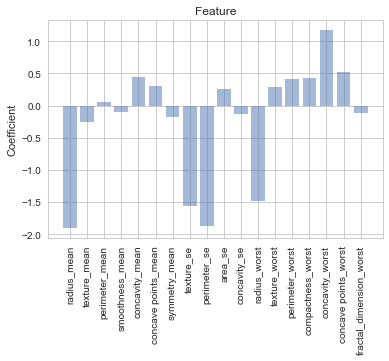

<Figure size 6400x4800 with 0 Axes>

In [408]:
gen_confusion(logreg, X_test)
gen_kfold(linear_model.LogisticRegression(), X_train, y_train)

plot_coef_feature(logreg.coef_[0])

In [388]:
# Time for K Means
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

print_accuracy(knn.predict)

gen_confusion(knn, X_test)
gen_kfold(neighbors.KNeighborsClassifier(), X_train, y_train)

Accuracy = 95.32163742690058%
Accuracy of KNeighborsClassifierclassifier on test set: 0.95
[[103   5]
 [  3  60]]
10-fold cross validation average accuracy: 0.932


In [390]:
# SVM Time - Radial Kernal
svc_radial = svm.SVC(kernel='rbf', probability=True)
svc_radial.fit(X_train, y_train)
print_accuracy(svc_radial.predict)

gen_confusion(svc_radial, X_test)
gen_kfold(svm.SVC(kernel='rbf', probability=True), X_train, y_train, "Radial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_radial.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 90.64327485380117%
Accuracy of SVCclassifier on test set: 0.91
[[93 15]
 [ 1 62]]
10-fold cross validation average accuracy: 0.876


In [306]:
# SVM Time - Sigmoid Kernal
svc_sigmoid = svm.SVC(kernel='sigmoid', probability=True)
svc_sigmoid.fit(X_train, y_train)
print_accuracy(svc_sigmoid.predict)

gen_confusion(svc_sigmoid, X_test)
gen_kfold(svm.SVC(kernel='sigmoid', probability=True), X_train, y_train, "Sigmoid Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_sigmoid.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 63.1578947368421%
Accuracy of SVCclassifier on test set: 0.63
[[108   0]
 [ 63   0]]
10-fold cross validation average accuracy: 0.625


In [307]:
# SVM Time - Polynomial Kernal
svc_poly = svm.SVC(kernel='poly', probability=True)
svc_poly.fit(X_train, y_train)
print_accuracy(svc_poly.predict)

gen_confusion(svc_poly, X_test)
gen_kfold(svm.SVC(kernel='poly', probability=True), X_train, y_train, "Polynomial Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 92.98245614035088%
Accuracy of SVCclassifier on test set: 0.93
[[98 10]
 [ 2 61]]
10-fold cross validation average accuracy: 0.947


In [308]:
# SVM Time - Linear Kernal
svc_linear = svm.SVC(kernel='linear', probability=True)
svc_linear.fit(X_train, y_train)
print_accuracy(svc_linear.predict)


gen_confusion(svc_linear, X_test)
gen_kfold(svm.SVC(kernel='linear', probability=True), X_train, y_train, "Linear Kernal")

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(svc_linear.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 95.90643274853801%
Accuracy of SVCclassifier on test set: 0.96
[[102   6]
 [  1  62]]
10-fold cross validation average accuracy: 0.945


Accuracy = 94.73684210526316%
Accuracy of RandomForestClassifierclassifier on test set: 0.95
[[103   5]
 [  4  59]]
10-fold cross validation average accuracy: 0.947


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 3, False), ('compactness_mean', 8, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 14, False), ('fractal_dimension_mean', 16, False), ('radius_se', 7, False), ('texture_se', 10, False), ('perimeter_se', 4, False), ('area_se', 1, True), ('smoothness_se', 13, False), ('compactness_se', 12, False), ('concavity_se', 9, False), ('concave points_se', 11, False), ('symmetry_se', 15, False), ('fractal_dimension_se', 6, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 2, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 5, False)]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None

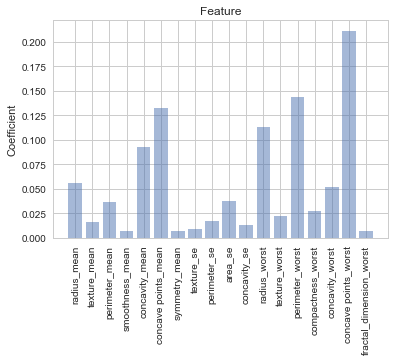

<Figure size 6400x4800 with 0 Axes>

In [411]:
# Random Forest Time
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
rforest.fit(X_train, y_train)
print_accuracy(rforest.predict)

gen_confusion(rforest, X_test)
gen_kfold(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0), X_train, y_train)

# TODO Generate these graphs
# shap_values = shap.KernelExplainer(rforest.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
gen_rfe(RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0))
plot_coef_feature(rforest.feature_importances_)

Accuracy = 91.81286549707602%
Accuracy of DecisionTreeClassifierclassifier on test set: 0.92
[[97 11]
 [ 3 60]]
10-fold cross validation average accuracy: 0.917
[('radius_mean', 16, False), ('texture_mean', 12, False), ('perimeter_mean', 11, False), ('area_mean', 10, False), ('smoothness_mean', 8, False), ('compactness_mean', 6, False), ('concavity_mean', 5, False), ('concave points_mean', 1, True), ('symmetry_mean', 3, False), ('fractal_dimension_mean', 2, False), ('radius_se', 1, True), ('texture_se', 13, False), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 1, True), ('compactness_se', 1, True), ('concavity_se', 9, False), ('concave points_se', 7, False), ('symmetry_se', 4, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_w

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


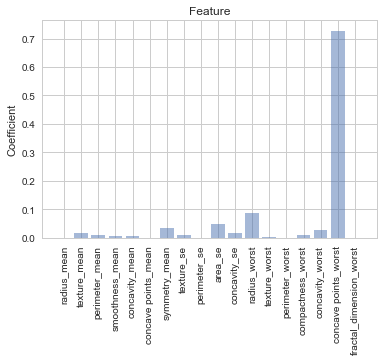

<Figure size 6400x4800 with 0 Axes>

In [412]:
# Decision Tree Time
dtree = tree.DecisionTreeClassifier(min_samples_split=2)
dtree.fit(X_train, y_train)
print_accuracy(dtree.predict)

gen_confusion(dtree, X_test)
gen_kfold(tree.DecisionTreeClassifier(min_samples_split=2), X_train, y_train)


# TODO Generate these graphs
# shap_values = shap.KernelExplainer(dtree.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)
gen_rfe(tree.DecisionTreeClassifier(min_samples_split=2))
plot_coef_feature(dtree.feature_importances_)

In [415]:
# Simple Neural Net
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0)
nn.fit(X_train, y_train)
print_accuracy(nn.predict)

gen_confusion(nn, X_test)
gen_kfold(MLPClassifier(solver='lbfgs', alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0), X_train, y_train)

# explain all the predictions in the test set
# shap_values = shap.KernelExplainer(nn.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 92.98245614035088%
Accuracy of MLPClassifierclassifier on test set: 0.93
[[99  9]
 [ 3 60]]
10-fold cross validation average accuracy: 0.947


In [417]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print_accuracy(gnb.predict)

gen_confusion(gnb, X_test)
gen_kfold(GaussianNB(), X_train, y_train)
# shap_values = shap.KernelExplainer(gnb.predict_proba, X_train).shap_values(X_test)
# shap.force_plot(shap_values[0], X_test)

Accuracy = 91.2280701754386%
Accuracy of GaussianNBclassifier on test set: 0.91
[[101   7]
 [  8  55]]
10-fold cross validation average accuracy: 0.942


Accuracy = 85.96491228070175%
Accuracy of SGDClassifierclassifier on test set: 0.86
[[102   6]
 [ 18  45]]
10-fold cross validation average accuracy: 0.767
[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 10, False), ('concavity_mean', 1, True), ('concave points_mean', 6, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 4, False), ('radius_se', 9, False), ('texture_se', 1, True), ('perimeter_se', 3, False), ('area_se', 1, True), ('smoothness_se', 14, False), ('compactness_se', 13, False), ('concavity_se', 11, False), ('concave points_se', 15, False), ('symmetry_se', 12, False), ('fractal_dimension_se', 16, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 5, False), ('concavity_worst', 1, True), ('concave points_worst', 7, False), ('symmetry_wor

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


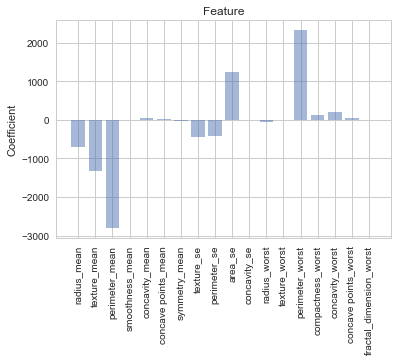

<Figure size 6400x4800 with 0 Axes>

In [420]:
# SGD Classifier
clf = linear_model.SGDClassifier(max_iter=30, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(max_iter=100, tol=1e-3), X_train, y_train)
gen_rfe(linear_model.SGDClassifier(max_iter=30, tol=1e-3))
plot_coef_feature(clf.coef_[0])

Accuracy = 83.04093567251462%
Accuracy of SGDClassifierclassifier on test set: 0.83
[[105   3]
 [ 26  37]]
10-fold cross validation average accuracy: 0.792
[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 2, False), ('compactness_mean', 10, False), ('concavity_mean', 1, True), ('concave points_mean', 6, False), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 4, False), ('radius_se', 9, False), ('texture_se', 1, True), ('perimeter_se', 8, False), ('area_se', 1, True), ('smoothness_se', 12, False), ('compactness_se', 13, False), ('concavity_se', 14, False), ('concave points_se', 15, False), ('symmetry_se', 11, False), ('fractal_dimension_se', 16, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 3, False), ('concavity_worst', 1, True), ('concave points_worst', 7, False), ('symmetry_wor

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


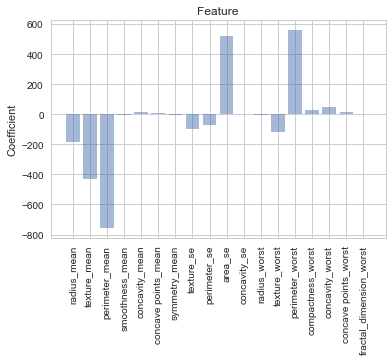

<Figure size 6400x4800 with 0 Axes>

In [421]:
# Perceptron
iteration = 10
clf = linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3), X_train, y_train)
gen_rfe(linear_model.SGDClassifier(loss="perceptron", eta0=1, learning_rate="constant", penalty=None, max_iter=iteration, tol=1e-3))
plot_coef_feature(clf.coef_[0])

Computing regularization path using the LARS ...
.

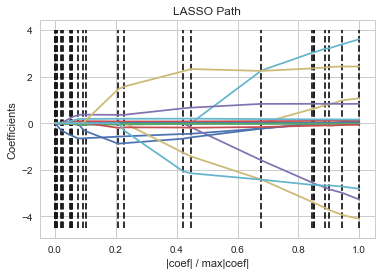

In [315]:

print("Computing regularization path using the LARS ...")
alphas, _, coefs = linear_model.lars_path(X_train.as_matrix(), y_train, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

In [316]:
# Radius Neighbors Classifier
radius = 70
rnc = neighbors.RadiusNeighborsClassifier(radius = radius)
rnc.fit(X_train, y_train)

print_accuracy(rnc.predict)

gen_confusion(rnc, X_test)
gen_kfold(neighbors.RadiusNeighborsClassifier(radius = radius), X_train, y_train)

Accuracy = 82.45614035087719%
Accuracy of RadiusNeighborsClassifierclassifier on test set: 0.82
[[108   0]
 [ 30  33]]
10-fold cross validation average accuracy: 0.834


In [317]:
# Neartest Shrunken Centroid
clf = neighbors.NearestCentroid(shrink_threshold=.1)
clf.fit(X_train, y_train)

print_accuracy(clf.predict)

gen_confusion(clf, X_test)
gen_kfold(neighbors.NearestCentroid(shrink_threshold=.1), X_train, y_train)

Accuracy = 88.30409356725146%
Accuracy of NearestCentroidclassifier on test set: 0.88
[[106   2]
 [ 18  45]]
10-fold cross validation average accuracy: 0.895


In [423]:
# Gaussian Process Classifier - 1.0 * RBF(1.0)
gausc = gaussian_process.GaussianProcessClassifier()
gausc.fit(X_train, y_train)

print_accuracy(gausc.predict)

gen_confusion(gausc, X_test)
gen_kfold(gaussian_process.GaussianProcessClassifier(), X_train, y_train)

Accuracy = 93.5672514619883%
Accuracy of GaussianProcessClassifierclassifier on test set: 0.94
[[100   8]
 [  3  60]]
10-fold cross validation average accuracy: 0.912


In [428]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print_accuracy(lda.predict)

gen_confusion(lda, X_test)
gen_kfold(LinearDiscriminantAnalysis(), X_train, y_train)
gen_rfe(LinearDiscriminantAnalysis())
plot_coef_feature(lda.feature_importances_)

Accuracy = 95.32163742690058%
Accuracy of LinearDiscriminantAnalysisclassifier on test set: 0.95
[[108   0]
 [  8  55]]
10-fold cross validation average accuracy: 0.960
[('radius_mean', 7, False), ('texture_mean', 14, False), ('perimeter_mean', 8, False), ('area_mean', 16, False), ('smoothness_mean', 1, True), ('compactness_mean', 1, True), ('concavity_mean', 2, False), ('concave points_mean', 1, True), ('symmetry_mean', 1, True), ('fractal_dimension_mean', 1, True), ('radius_se', 1, True), ('texture_se', 11, False), ('perimeter_se', 4, False), ('area_se', 13, False), ('smoothness_se', 1, True), ('compactness_se', 1, True), ('concavity_se', 1, True), ('concave points_se', 1, True), ('symmetry_se', 3, False), ('fractal_dimension_se', 6, False), ('radius_worst', 5, False), ('texture_worst', 10, False), ('perimeter_worst', 12, False), ('area_worst', 15, False), ('smoothness_worst', 1, True), ('compactness_worst', 9, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), 

/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'LinearDiscriminantAnalysis' object has no attribute 'feature_importances_'

Accuracy = 94.15204678362574%
Accuracy of ExtraTreesClassifierclassifier on test set: 0.94
[[105   3]
 [  7  56]]
10-fold cross validation average accuracy: 0.957


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 1, True), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 5, False), ('compactness_mean', 3, False), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 15, False), ('fractal_dimension_mean', 11, False), ('radius_se', 13, False), ('texture_se', 14, False), ('perimeter_se', 1, True), ('area_se', 1, True), ('smoothness_se', 7, False), ('compactness_se', 12, False), ('concavity_se', 8, False), ('concave points_se', 9, False), ('symmetry_se', 16, False), ('fractal_dimension_se', 10, False), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 4, False), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 2, False), ('fractal_dimension_worst', 6, False)]
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, 

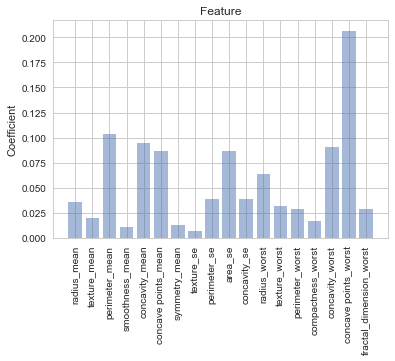

<Figure size 6400x4800 with 0 Axes>

In [429]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

print_accuracy(etc.predict)

gen_confusion(etc, X_test)
gen_kfold(ExtraTreesClassifier(), X_train, y_train)
gen_rfe(ExtraTreesClassifier())
plot_coef_feature(etc.feature_importances_)

Accuracy = 97.6608187134503%
Accuracy of GradientBoostingClassifierclassifier on test set: 0.98
[[106   2]
 [  2  61]]
10-fold cross validation average accuracy: 0.950


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 10, False), ('texture_mean', 1, True), ('perimeter_mean', 1, True), ('area_mean', 1, True), ('smoothness_mean', 15, False), ('compactness_mean', 1, True), ('concavity_mean', 9, False), ('concave points_mean', 1, True), ('symmetry_mean', 8, False), ('fractal_dimension_mean', 14, False), ('radius_se', 3, False), ('texture_se', 13, False), ('perimeter_se', 12, False), ('area_se', 1, True), ('smoothness_se', 2, False), ('compactness_se', 5, False), ('concavity_se', 4, False), ('concave points_se', 7, False), ('symmetry_se', 16, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 1, True), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 6, False), ('fractal_dimension_worst', 11, False)]
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss=

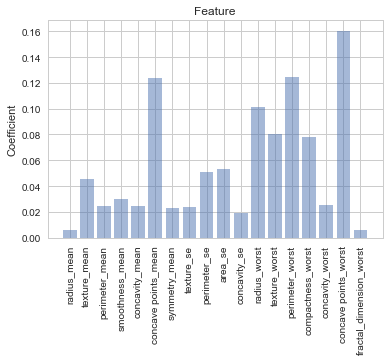

<Figure size 6400x4800 with 0 Axes>

In [430]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

print_accuracy(gbc.predict)

gen_confusion(gbc, X_test)
gen_kfold(GradientBoostingClassifier(), X_train, y_train)
gen_rfe(GradientBoostingClassifier())
plot_coef_feature(gbc.feature_importances_)

In [432]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Quadrati Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print_accuracy(qda.predict)

gen_confusion(qda, X_test)
gen_kfold(QuadraticDiscriminantAnalysis(), X_train, y_train)

Accuracy = 91.2280701754386%
Accuracy of QuadraticDiscriminantAnalysisclassifier on test set: 0.91
[[100   8]
 [  7  56]]
10-fold cross validation average accuracy: 0.952


Accuracy = 95.90643274853801%
Accuracy of AdaBoostClassifierclassifier on test set: 0.96
[[105   3]
 [  4  59]]
10-fold cross validation average accuracy: 0.972


/Users/BekkBlando/Documents/github/wisconsin_data/.direnv/python-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[('radius_mean', 16, False), ('texture_mean', 1, True), ('perimeter_mean', 14, False), ('area_mean', 12, False), ('smoothness_mean', 2, False), ('compactness_mean', 1, True), ('concavity_mean', 1, True), ('concave points_mean', 1, True), ('symmetry_mean', 10, False), ('fractal_dimension_mean', 15, False), ('radius_se', 5, False), ('texture_se', 3, False), ('perimeter_se', 9, False), ('area_se', 1, True), ('smoothness_se', 8, False), ('compactness_se', 1, True), ('concavity_se', 13, False), ('concave points_se', 11, False), ('symmetry_se', 4, False), ('fractal_dimension_se', 1, True), ('radius_worst', 1, True), ('texture_worst', 1, True), ('perimeter_worst', 6, False), ('area_worst', 1, True), ('smoothness_worst', 1, True), ('compactness_worst', 1, True), ('concavity_worst', 1, True), ('concave points_worst', 1, True), ('symmetry_worst', 1, True), ('fractal_dimension_worst', 7, False)]
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators

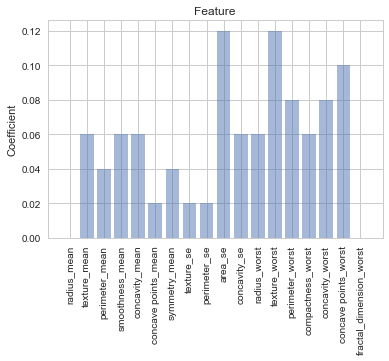

<Figure size 6400x4800 with 0 Axes>

In [434]:
# Ada Classifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

print_accuracy(ada.predict)

gen_confusion(ada, X_test)
gen_kfold(AdaBoostClassifier(), X_train, y_train)
gen_rfe(AdaBoostClassifier())
plot_coef_feature(ada.feature_importances_)

In [324]:
labels = [pair[0] for pair in accuracy]
acc = [pair[1] for pair in accuracy]
y_pos = np.arange(len(acc))

<Figure size 6400x4800 with 0 Axes>

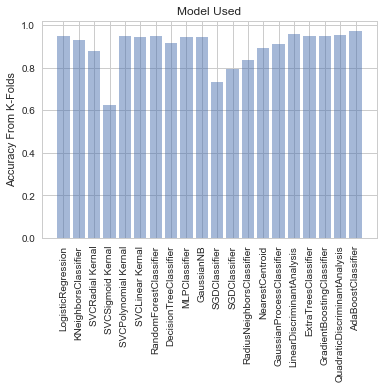

<Figure size 6400x4800 with 0 Axes>

In [330]:
plt.bar(y_pos, acc, align='center', alpha=0.5)
plt.xticks(y_pos, labels, rotation='vertical')
plt.ylabel('Accuracy From K-Folds')
plt.title('Model Used')
 
plt.figure(num=None, figsize=(80, 60), dpi=80, facecolor='w', edgecolor='k')